In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

ModuleNotFoundError: No module named 'fastai'

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import fastai
print("fastai: ",fastai.__version__)
import torch
print("Torch: ",torch.__version__)
import torchvision
print("Torchvision: ",torchvision.__version__)
import sklearn
print("sklearn: ",sklearn.__version__)
import sys
print("Python: ",sys.version)

In [ ]:
!nvidia-smi

In [ ]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    print("GPU: ",torch.cuda.get_device_name(devID))
else:
    print("Torch Cuda not avaialbe")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
PATH = Path('../../../../../data/StanfordCars')

In [ ]:
import os
print(os.listdir(PATH))

In [ ]:
PATH.ls()

In [3]:
path_train = PATH/'cars_train'
path_test = PATH/'cars_test'

NameError: name 'PATH' is not defined

In [ ]:
fnames = get_image_files(path_train)
fnames[:5]

In [ ]:
len(fnames)

In [ ]:
img = plt.imread(fnames[2])
plt.imshow(img);

In [ ]:
pic = Path('../../../../../data/StanfordCars/cars_train/00001.jpg')
img = plt.imread(pic)
plt.imshow(img);

In [ ]:
fnames[:5]

In [ ]:
import scipy.io
cars_annos = scipy.io.loadmat(PATH/'cars_annos.mat')

In [ ]:
type(cars_annos)

In [ ]:
cars_annos

In [ ]:
 _, total_size = cars_annos["annotations"].shape
print("total sample size is ", total_size)
labels = np.zeros((total_size, 5))
for i in range(total_size):
    path = cars_annos["annotations"][:,i][0][0][0].split(".")
    id = int(path[0][8:]) - 1
    for j in range(5):
        labels[id, j] = int(cars_annos["annotations"][:,i][0][j + 1][0])

In [ ]:
labels[0]

In [ ]:
cars_annos["annotations"][0][0][0]

In [ ]:
print(os.listdir(f'{PATH}/devkit'))

In [ ]:
print("Class Names")
print(cars_annos["class_names"][0][0])

In [ ]:
class_annos = scipy.io.loadmat(PATH/'devkit/cars_meta.mat')

In [ ]:
class_annos

In [ ]:
class_annos["class_names"][0][14][0]

In [ ]:
train_annos = scipy.io.loadmat(PATH/'devkit/cars_train_annos.mat')

In [ ]:
train_annos

In [ ]:
train_annos["annotations"][0][0][4][0][0]

In [ ]:
train_annos["annotations"][0][0][5][0]

In [ ]:
total_set = len(train_annos["annotations"][0])
print(f'Total number of data items in dataset: {total_set}')

In [ ]:
classes_total = len(class_annos["class_names"][0])
print(f'Total number of classes: {classes_total}')

In [ ]:
#                                               fname                                         class
classes = [[f'cars_train/{train_annos["annotations"][0][i][5][0]}',train_annos["annotations"][0][i][4][0][0]] for i in range(total_set)]
classes[:5]

In [ ]:
# Create the pandas DataFrame 
df = pd.DataFrame(classes, columns = ['name', 'label']) 
  
# print dataframe. 
df.head()


In [ ]:
df.tail()

In [ ]:
len(df['label'].unique())

In [ ]:
len(class_annos["class_names"][0])

In [ ]:
df['label'].min()

In [ ]:
# match label [1..196] to [0..195]
df['label'] = df['label']-1
df['label'].min()

In [ ]:
class_annos["class_names"][0][1][0]

In [ ]:
class_annos

In [ ]:
total_labels = len(class_annos["class_names"][0])
total_labels

In [ ]:
labels = [class_annos["class_names"][0][i][0] for i in range(total_labels)]
labels[:5]

In [ ]:
len(labels)

In [ ]:
df_label = pd.DataFrame(labels)
df_label.head()

In [ ]:
df_label.tail()

In [ ]:
df_label.shape

In [ ]:
new_labels = pd.DataFrame(df_label[0][df['label']])
#new_labels = labels[df['label']]

In [ ]:
new_labels.head()

In [ ]:
new_labels.reset_index(inplace=True)
new_labels.head()

In [ ]:
new_labels=new_labels.drop(columns='index', axis=1)
new_labels.head()

In [ ]:
# reaplace integer classes with strint labels
df['label'] = new_labels

In [ ]:
df.head()

In [ ]:
df['label'].isnull().any()

In [ ]:
#??ImageDataBunch.from_df

In [ ]:
np.random.seed(42)

In [ ]:
data = ImageDataBunch.from_df(PATH, df, valid_pct=0.2, ds_tfms=get_transforms(),
                              size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.classes

In [ ]:
data.show_batch(rows=3, figsize=(15,12))

In [ ]:
data.c, len(data.train_ds), len(data.valid_ds)


In [295]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/norvilr/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:08<00:00, 10378770.31it/s]


In [296]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,5.246243,4.122812,0.859951,00:46
1,3.902167,2.973322,0.689189,00:46
2,3.008107,2.506297,0.613636,00:46
3,2.478111,2.422665,0.582924,00:46


In [297]:
learn.unfreeze()

In [298]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


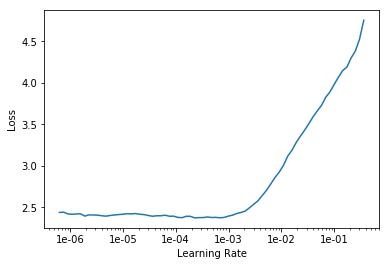

In [299]:
learn.recorder.plot()

In [301]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.009075,1.342061,0.345209,00:46
1,1.270342,1.507758,0.414619,00:46
2,0.935459,1.047532,0.286241,00:46
3,0.572422,0.770930,0.210074,00:46
4,0.355133,0.731964,0.201474,00:46


In [302]:
# error_rate still dropping, few more cycles
learn.fit_one_cycle(5, max_lr=slice(5e-5,5e-4,5e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.305802,0.750199,0.210074,00:47
1,0.397654,0.887203,0.245700,00:47
2,0.332529,0.784488,0.218059,00:47
3,0.213238,0.680550,0.191032,00:47
4,0.152631,0.664092,0.181818,00:47


In [303]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


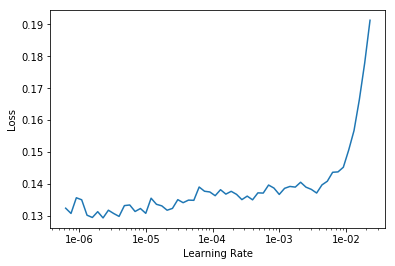

In [304]:
learn.lr_find()
learn.recorder.plot()

In [308]:
learn.fit_one_cycle(3, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.144983,0.666113,0.183047,00:45
1,0.144125,0.664480,0.184275,00:46
2,0.137182,0.661225,0.181818,00:46


In [310]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

In [312]:
data2 = ImageDataBunch.from_df(PATH, df, valid_pct=0.2, ds_tfms=get_transforms(),
                              size=299, num_workers=4).normalize(imagenet_stats)
learn.data = data2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


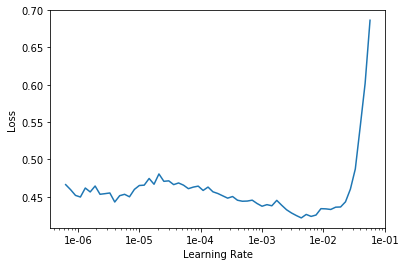

In [313]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [314]:
learn.fit_one_cycle(4, max_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.390984,0.244038,0.065111,00:54
1,0.460773,0.244105,0.067568,00:54
2,0.339940,0.197266,0.062039,00:53
3,0.237063,0.186706,0.053440,00:53


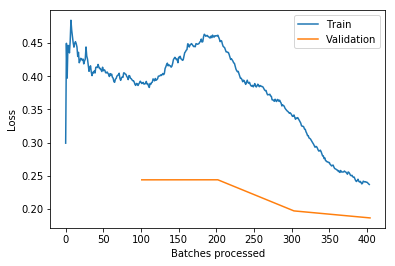

In [315]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


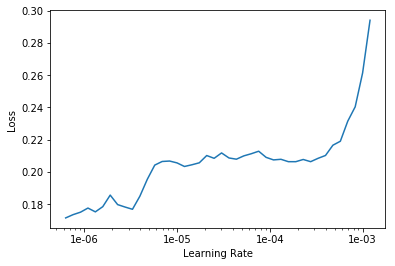

In [316]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [317]:
learn.fit_one_cycle(4, max_lr=slice(3e-6, 3e-3/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.213291,0.196111,0.051597,00:53
1,0.206041,0.200121,0.057125,00:53
2,0.165662,0.183734,0.055897,00:53
3,0.138683,0.179108,0.054054,00:53


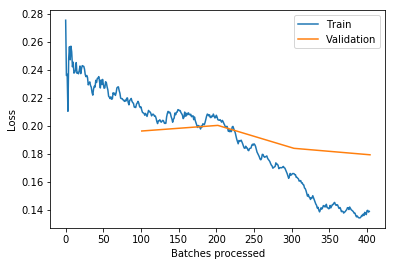

In [318]:
learn.recorder.plot_losses()

In [319]:
learn.save('229_all')

In [320]:
interp = ClassificationInterpretation.from_learner(learn)

/home/norvilr/anaconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


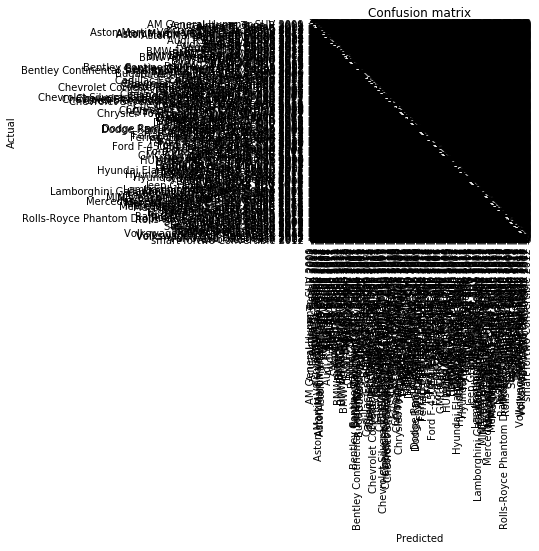

In [321]:
interp.plot_confusion_matrix()

In [322]:
%time log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

CPU times: user 2min 17s, sys: 3min 42s, total: 6min
Wall time: 1min 44s


TypeError: mean() missing 3 required positional argument: "dim", "keepdim", "dtype"

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


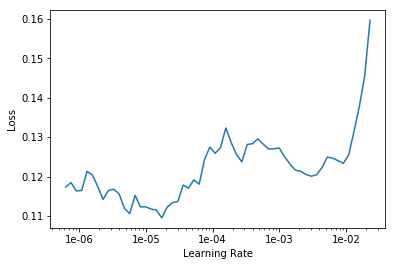

In [323]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [324]:
learn.fit_one_cycle(4, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.129223,0.178952,0.052826,00:52
1,0.133058,0.178400,0.052211,00:53
2,0.122846,0.178798,0.054668,00:53
3,0.124975,0.178595,0.052826,00:53


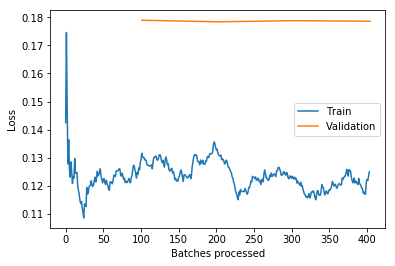

In [325]:
learn.recorder.plot_losses()